In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

import scipy.stats
import numpy as np

# The model and simulations.

To match with the INLA notation, the $\theta$ parameter for Berry et al 2013 is called $x$ here. Also, Berry uses:
\begin{equation}
\tilde{x} = logit(p) - logit(p_1)
\end{equation}
whereas we use:
\begin{equation}
x = logit(p) = \tilde{x} + logit(p_1)
\end{equation}

In [2]:
p0 = np.full(1, 0.1) # rate of response below this is the null hypothesis
p1 = np.full(1, 0.3) # rate of response above this is the alternative hypothesis.
# rate of response > p0 and < p1 is gray area.
p0_theta = scipy.special.logit(p0)

pmid = (p0 + p1) / 2
pmid_theta = scipy.special.logit(pmid)

 # final evaluation criterion 
 # accept the alternative hypo if Pr(p[i] > p0|data) > pfinal_thresh[i]
pfinal_thresh = np.full(1, 0.85)

# early stopping criterion
pmid_accept = 0.9
pmid_fail = 0.05

null_x_berry = np.log(p0 / (1 - p0)) - np.log(p1 / (1 - p1))
null_x = np.log(p0 / (1 - p0))
prior_mu_mean = null_x[0]
null_x, null_x_berry

(array([-2.19722458]), array([-1.34992672]))

In [3]:

def berry_prior(theta):
    mu = theta[..., 0]
    mu_prior = scipy.stats.norm.logpdf(mu, prior_mu_mean, 100)

    sigma2 = theta[..., 1]
    alpha = 0.0005
    beta = 0.000005
    sigma2_prior = scipy.stats.invgamma.logpdf(sigma2, alpha, scale=beta)
    # sigma2_prior = scipy.stats.uniform.logpdf(sigma2, loc=0.01, scale=1)
    return mu_prior + sigma2_prior

In [4]:
import inla

# I got this data by deconstructing the graphs in in Figure 1 of Berry et al 2013.
n_i = np.array([[i * 4] for i in [10,15,20,25,30,35]])
y_i = np.array([[1, 6, 3, 3], [3, 8, 5, 4], [6,9,7,5], [7,10,8,7], [8,10,9,8], [11, 11, 10, 9]])
y_i = np.sum(y_i, axis=1)[:, None]
data = np.stack((y_i, n_i), axis=2)

model = inla.binomial_hierarchical()
model.log_prior = berry_prior

mu_rule = inla.simpson_rule(241, -3, 3)
sigma2_rule = inla.composite_simpson_rule(
    # (31, 1e-7, 1e-6),
    # (31, 1e-6, 1e-5),
    # (31, 1e-5, 1e-4),
    # (31, 1e-4, 1e-3),
    # (31, 5e-3, 1e-2),
    (31, 1e-2, 1e0),
    (31, 1e0, 1e1),
    # (31, 1e2, 1e4),
)

post_theta, logpost_theta_data = inla.calc_posterior_theta(model, data, (mu_rule, sigma2_rule))

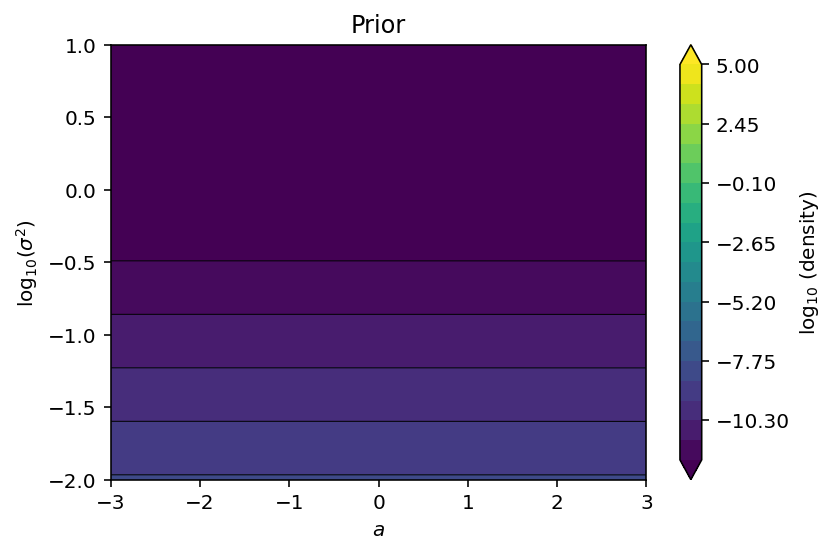

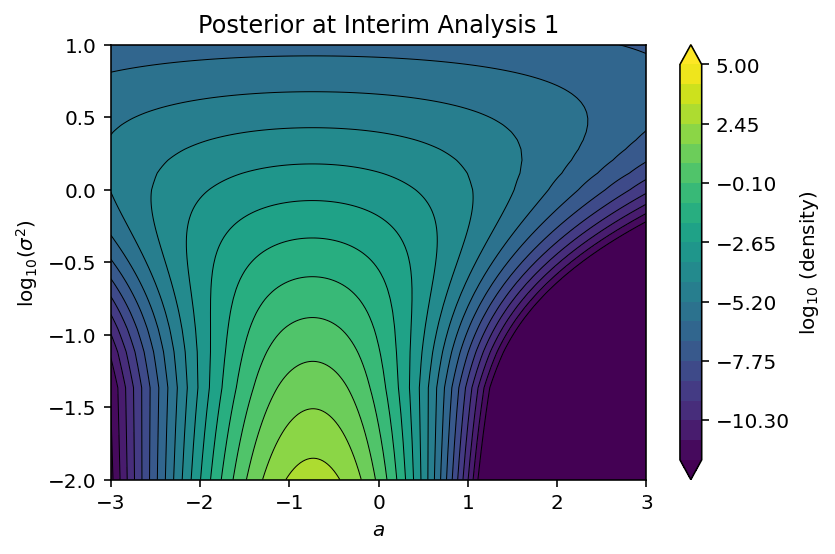

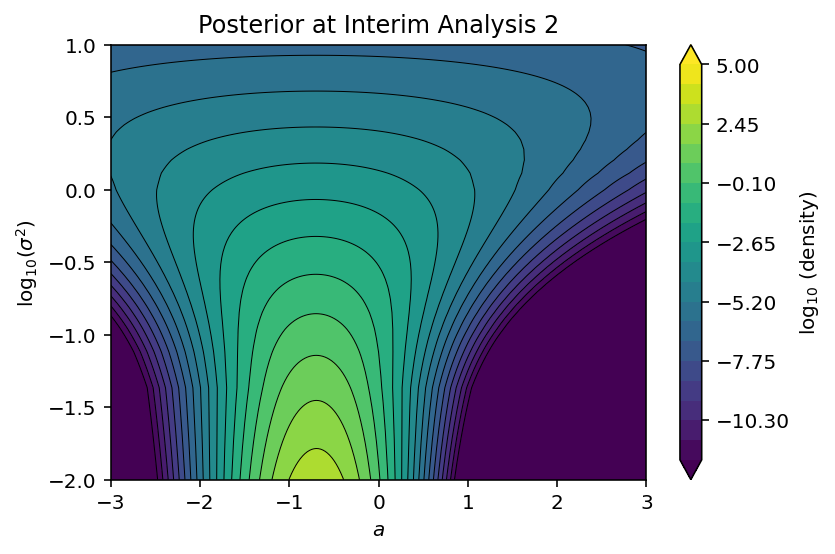

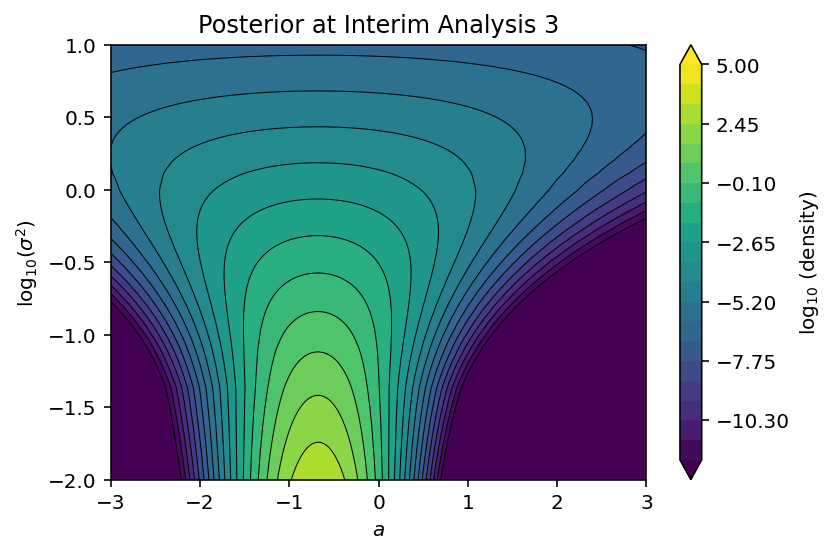

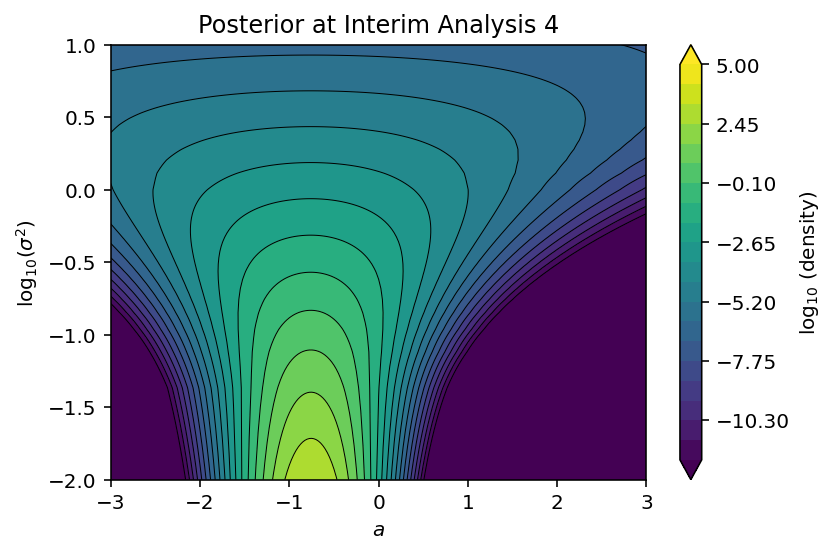

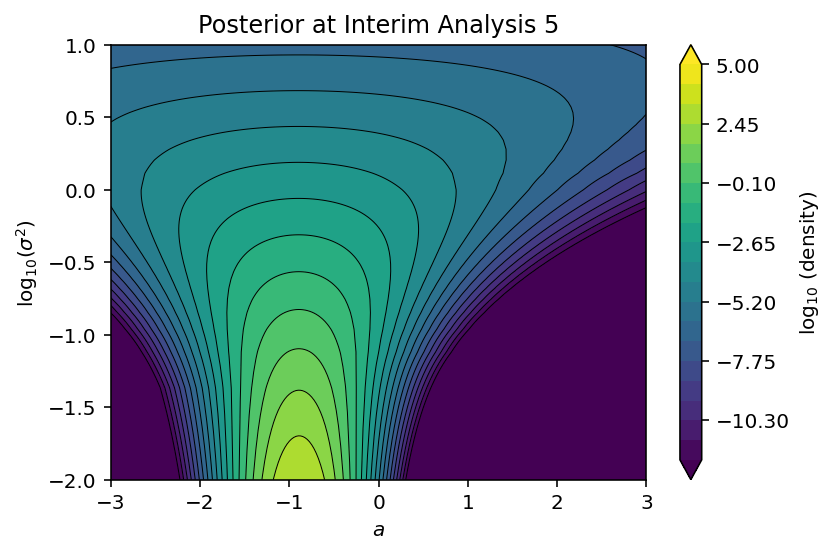

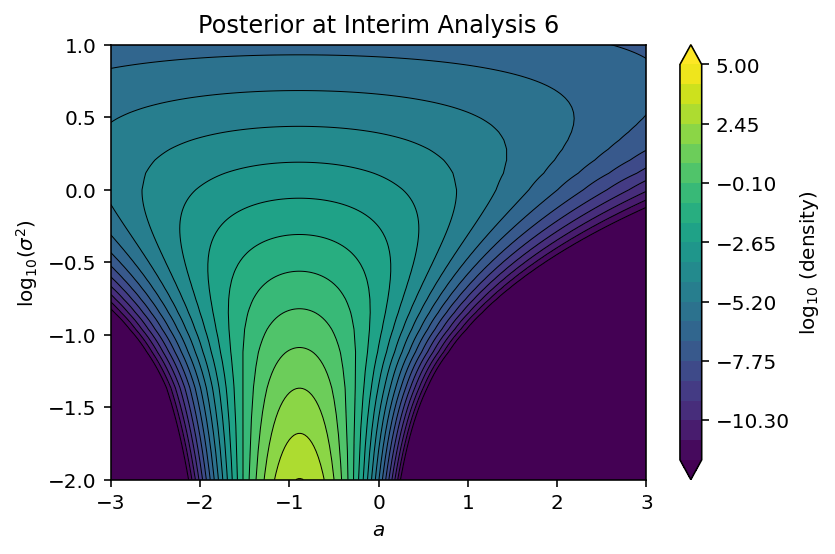

In [7]:
# Plot the theta prior and posteriors.
MM = logpost_theta_data["theta_grid"][:,:,0]
SS = logpost_theta_data["theta_grid"][:,:,1]
# sigma_grid = np.sqrt(SS)
sigma_grid = np.log10(SS)
levels = np.linspace(-12, 5, 21)
for i in range(-1, 6):
    if i == -1:
        field = model.log_prior(np.stack((MM.flatten(), SS.flatten()), axis=1)[:,None,:])
        plt.title("Prior")
    else:
        field = np.log(np.abs(post_theta[i]))
        field[np.isnan(field) | np.isinf(field)] = -20
        plt.title(f"Posterior at Interim Analysis {i+1}")
    cntf = plt.contourf(
        MM, sigma_grid, field.reshape(MM.shape), levels=levels, extend="both"
    )
    plt.contour(
        MM,
        sigma_grid,
        field.reshape(MM.shape),
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    cbar = plt.colorbar(cntf)
    cbar.set_label('$\log_{10}$ (density)')
    plt.xlabel("$a$")
    plt.ylabel("$\log_{10} (\sigma^2)$")
    plt.show()

In [11]:
mu_post, sigma_post = inla.calc_posterior_x(post_theta, logpost_theta_data)

p_post = scipy.special.expit(mu_post)
cilow = scipy.special.expit(mu_post - 2 * sigma_post)
cihigh = scipy.special.expit(mu_post + 2 * sigma_post)

y = data[:, :, 0]
n = data[:, :, 1]
raw_ratio = y / n
p_success = np.empty_like(mu_post)
# early stopping criterion
p_success[:5] = 1.0 - scipy.stats.norm.cdf(pmid_theta, mu_post[:5], sigma_post[:5])
# final success criterion
p_success[5] = 1.0 - scipy.stats.norm.cdf(p0_theta, mu_post[5], sigma_post[5])

In [12]:
pmid, p_post, cilow, cihigh

(array([0.2]),
 array([[0.3276299 ],
        [0.33319693],
        [0.33698665],
        [0.3194962 ],
        [0.2911517 ],
        [0.29206566]]),
 array([[0.19844378],
        [0.22393542],
        [0.24038179],
        [0.23406592],
        [0.21554961],
        [0.22165513]]),
 array([[0.48955169],
        [0.46390191],
        [0.44944432],
        [0.41904799],
        [0.38041151],
        [0.37409275]]))

In [13]:
map_idx = np.unravel_index(np.argmax(post_theta[0]), post_theta[0].shape)
map_idx
raw_ratio, mu_post, p_post, sigma_post, pmid_theta, p0_theta

(array([[0.325     ],
        [0.33333333],
        [0.3375    ],
        [0.32      ],
        [0.29166667],
        [0.29285714]]),
 array([[-0.71892431],
        [-0.69376104],
        [-0.67675181],
        [-0.75608802],
        [-0.88979708],
        [-0.8853727 ]]),
 array([[0.3276299 ],
        [0.33319693],
        [0.33698665],
        [0.3194962 ],
        [0.2911517 ],
        [0.29206566]]),
 array([[0.33856249],
        [0.2745585 ],
        [0.23691785],
        [0.21470266],
        [0.20099757],
        [0.18533714]]),
 array([-1.38629436]),
 array([-2.19722458]))

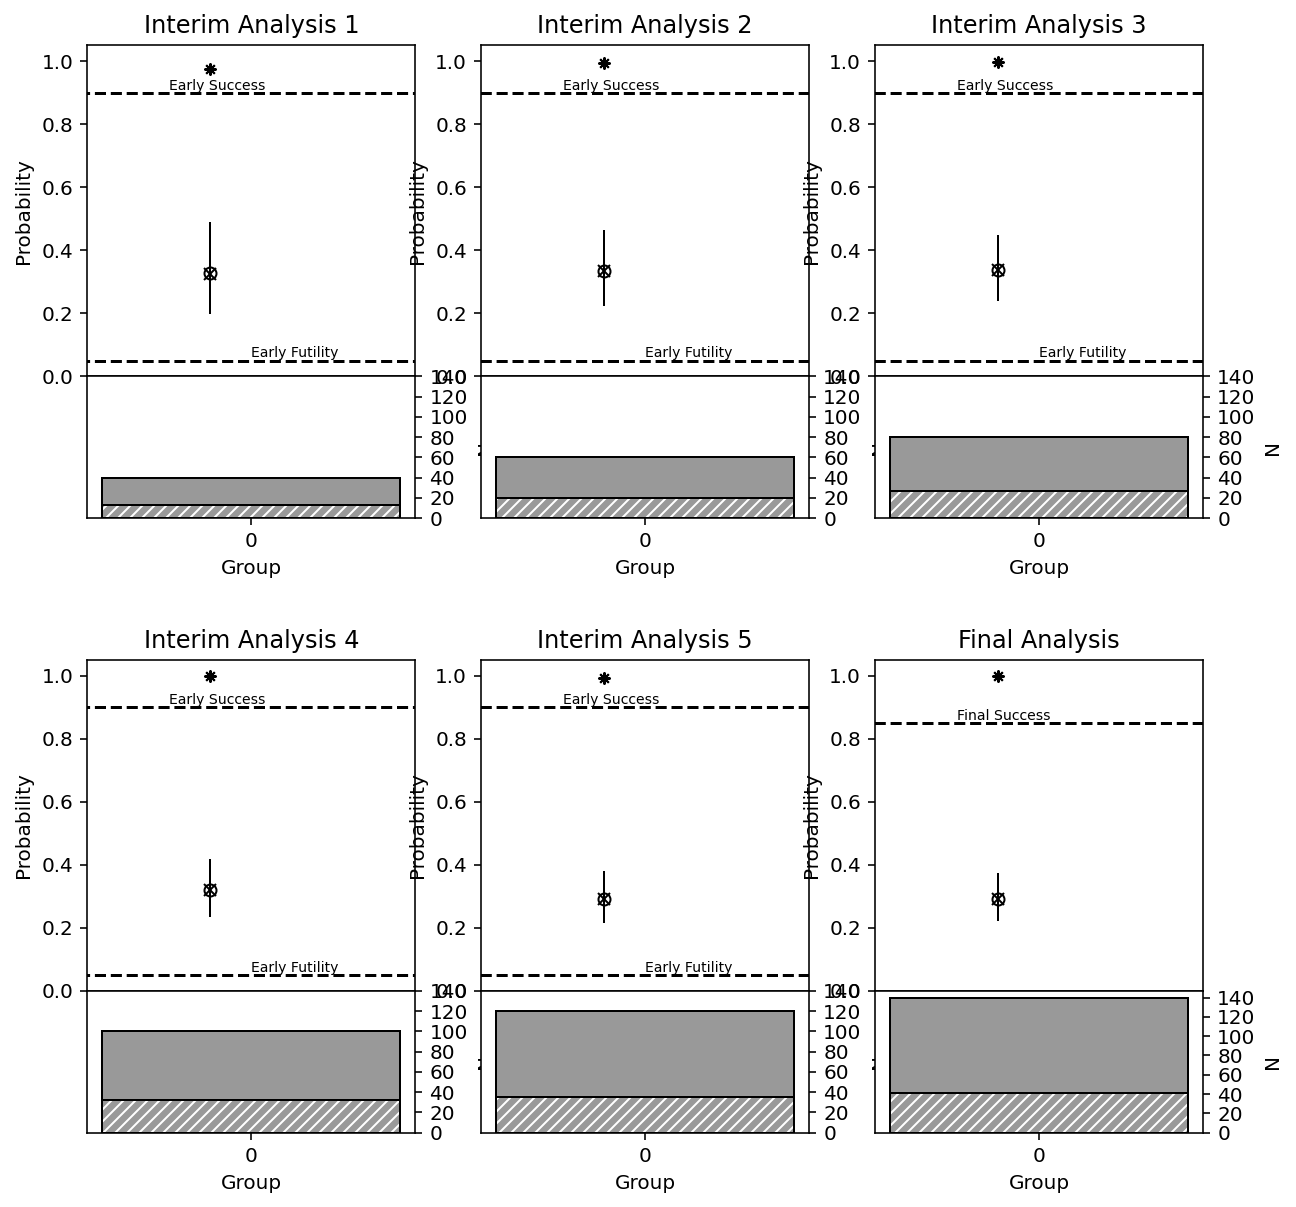

In [25]:

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 10))
outergs = fig.add_gridspec(2, 3, hspace=0.3)
for i in range(data.shape[0]):
    arms_idxs = np.arange(1)
    innergs = outergs[i].subgridspec(
        2, 1, wspace=0, hspace=0, height_ratios=[0.7, 0.3]
    )

    plt.subplot(innergs[0])
    plt.plot(arms_idxs, raw_ratio[i], "kx")
    plt.plot(arms_idxs, p_post[i], "ko", mfc="none")
    plt.plot(arms_idxs, p_success[i], "k ", marker=(8, 2, 0))

    plt.vlines(arms_idxs, cilow[i], cihigh[i], color="k", linewidth=1.0)

    if i < 5:
        plt.title(f"Interim Analysis {i+1}")
        plt.hlines([pmid_fail, pmid_accept], -1, 4, colors=["k"], linestyles=["--"])
        plt.text(-0.1, 0.91, "Early Success", fontsize=7)
        plt.text(0.1, 0.06, "Early Futility", fontsize=7)
    else:
        plt.title("Final Analysis")
        plt.hlines([pfinal_thresh[0]], -1, 4, colors=["k"], linestyles=["--"])
        plt.text(-0.1, 0.86, "Final Success", fontsize=7)

    plt.xlim([-0.3, 0.5])
    plt.ylim([0.0, 1.05])
    plt.xticks(arms_idxs)
    plt.yticks(np.linspace(0.0, 1.0, 6))
    plt.xlabel("Group")
    plt.ylabel("Probability")

    plt.subplot(innergs[1])
    plt.bar(
        arms_idxs,
        n_i[i],
        tick_label=[str(i) for i in arms_idxs],
        color=(0.6, 0.6, 0.6, 1.0),
        edgecolor="k",
        zorder=0,
    )
    plt.bar(
        arms_idxs,
        y_i[i],
        color=(0.6, 0.6, 0.6, 1.0),
        hatch="////",
        edgecolor="w",
        lw=1.0,
        zorder=1,
    )
    #         # draw hatch
    # ax1.bar(range(1, 5), range(1, 5), color='none', edgecolor='red', hatch="/", lw=1., zorder = 0)
    # # draw edge
    plt.bar(arms_idxs, y_i[i], color="none", edgecolor="k", zorder=2)
    ticks = np.arange(0, 141, 20)
    plt.yticks(ticks, [str(i) if i % 10 == 0 else "" for i in ticks])
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.xlabel("Group")
    plt.ylabel("N")

plt.show()
